# Large Language Model (LLM) Finetuning

This notebook contains code to evaluate an LLM on a subset of the [SQuAD dataset](https://huggingface.co/datasets/rajpurkar/squad) (Stanford Question Answering Dataset), fine-tune it on it and reevaluate to check model's performance. Along the way, we'll stop and explain several of the concepts involved across similar tasks.

## Problem Description

The problem at hand is a subfield of Natural Language Processing (NLP) called Question Answering (QA). The goal is to, asking an LLM a question given some context, receive an appropriate answer included in the beforementioned context. 

In [18]:
from transformers import DistilBertForQuestionAnswering, DistilBertTokenizerFast, Trainer, TrainingArguments, pipeline
from datasets import load_dataset
import evaluate
import Levenshtein

## The Model

Nowadays, LLMs are versatile enough to address this and many other problems through prompt engineering. Within this framework, engineers tweak their prompts in order to get the best possible results to their problems. However, generalist LLMs can become unfeasible to use depending on computational, budget and response time constraints. This is why, depending on the problem at hand, a more direct approach might be better fitting.  
One personally recommended course of action is to first check the available models that aims to solve the problem of interest. The HuggingFace (HF) Hub is a well known initiative where to check many resources, including models and datasets. This way, it's easy to check the best models for a particular task.  
Besides model comparison regarding purely evaluation metrics, other very important aspect of LLM deployment is its size. Many of them are traditionally large enough to prove themselves challenging to host. A useful tool might be the [Can you run it? LLM version](https://huggingface.co/spaces/Vokturz/can-it-run-llm) from HF. It allows the user to select a model, hardware, and the web will display if it's feasible or not to run it on 1 or more GPUs depending on quantization, training adequacy, etc.  
For this particular project, which is meant to showcase how to perform fine-tuning and evaluations in a normal setup rather than finding the best possible solution, we'll start from [DistilBERT base model](https://huggingface.co/distilbert/distilbert-base-uncased) rather than already fine-tuned ones in the desired Dataset.

In [2]:
model_name = "distilbert-base-uncased"
model = DistilBertForQuestionAnswering.from_pretrained(model_name)
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## The Dataset

The Dataset of interest is the Stanford Question Answering Dataset ([SQuAD](https://huggingface.co/datasets/rajpurkar/squad)). It comprehends a set of segments of text from Wikipedia (context) alongside questions and answers that can be found in the given context.

In [3]:
squad = load_dataset("squad")

### Dataset Preprocessing

Usually, Deep Learning (FL) applications require some preprocessing to their inputs. In NLP, this may involve some text cleaning, tokenization (technique that depends on the model of choice), truncation handling, etc.

In [4]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [5]:
tokenized_squad = squad.map(preprocess_function, batched=True, 
                            remove_columns=squad["train"].column_names)

## Fine-tuning

Training an LLM from scratch can be very slow and costly. Instead, one common practice in DL is to start from an already pre-trained model and start training from there (what we call fine-tuning). The code below shows the training configuration through HF: 

In [6]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=500,
    report_to="tensorboard", 
    save_steps=500,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

c:\Users\xavia\Projects\llm-finetuning\venv\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_squad["train"],
    eval_dataset=tokenized_squad["validation"],
)

Right after it, it's possible to evaluate the initial model against the SQuAD's *validation* subset:

In [11]:
trainer.evaluate()

100%|██████████| 661/661 [00:28<00:00, 22.93it/s]


{'eval_loss': 5.8978590965271,
 'eval_model_preparation_time': 0.001,
 'eval_runtime': 29.405,
 'eval_samples_per_second': 359.462,
 'eval_steps_per_second': 22.479}

After setting a baseline, let's start the QA model's fine-tuning.  
**Note:** This step can take a significant amount of time depending on hardware specifications:

In [ ]:
trainer.train()

This training will create some output logs that can be read with TensorBoard. You can start TensorBoard with the following command:

```bash
tensorboard --logdir logs/
```

TensorBoard provides useful information in a visual way. For example, monitoring the train and eval losses while training can give information about the current's training state. For instance, if both losses are high and do not decrease over time, the model may be underfitting. On the other hand, if the train loss decreases but the eval one starts to increase, it might be overfitting. Depending on the scenario, the engineer might choose to look for more powerful architectures, more broad and representative data, or start with hyperparameter (HP) tuning. The most common one to tweak is the Learning Rate (LR): one too big might yield to quick improvements at the risk of reaching a loss plateau. On the other hand, a smaller one might make the training too slow. It's recommended to play with HP for the optimizers (e.g. Adam) or different strategies to get the best possible results

If a model has already been fine-tuned, specify the checkpoint of your choice below to load it:

In [9]:
best_checkpoint = "./results/checkpoint-10000"

finetuned_model = DistilBertForQuestionAnswering.from_pretrained(best_checkpoint)
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

## Evaluation comparison

After having available both models, the pre-trained and the fine-tuned ones, let's make a more thorough evaluation comparison:

In [28]:
# Baseline model evaluation
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_squad["train"],
    eval_dataset=tokenized_squad["validation"],
)

trainer.evaluate()

100%|██████████| 661/661 [00:29<00:00, 22.71it/s]


{'eval_loss': 5.956923484802246,
 'eval_model_preparation_time': 0.001,
 'eval_runtime': 29.3675,
 'eval_samples_per_second': 359.922,
 'eval_steps_per_second': 22.508}

In [29]:
# Fine-tuned model evaluation
trainer = Trainer(
    model=finetuned_model,
    args=training_args,
    train_dataset=tokenized_squad["train"],
    eval_dataset=tokenized_squad["validation"],
)

trainer.evaluate()

100%|██████████| 661/661 [00:29<00:00, 22.56it/s]


{'eval_loss': 1.1106374263763428,
 'eval_model_preparation_time': 0.001,
 'eval_runtime': 29.3136,
 'eval_samples_per_second': 360.584,
 'eval_steps_per_second': 22.549}

The evaluation loss difference (lower is better) already shows that the fine-tuned model is better than the baseline.  
Furthermore, it's possible to make a more thorough analysis by generating the model's responses and performing an Error Analysis (EA). For that purpose, let's use the HF's *question answering pipeline*:

In [10]:
qa_pipeline = pipeline("question-answering", 
                       model="distilbert-base-uncased", 
                       tokenizer=tokenizer, 
                       batch_size=64)

finetuned_qa_pipeline = pipeline("question-answering", 
                                 model=finetuned_model, 
                                 tokenizer=tokenizer,
                                 batch_size=64)

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Then, let's reuse the SQuAD's validation dataset to store the predicted answers and scores for both models:

In [12]:
def get_prediction(example):
    baseline_prediction = qa_pipeline(question=example["question"], context=example["context"])
    finetuned_prediction = finetuned_qa_pipeline(question=example["question"], context=example["context"])
    return {
        "baseline_prediction": baseline_prediction["answer"],
        "baseline_score": baseline_prediction["score"],
        "finetuned_prediction": finetuned_prediction["answer"],
        "finetuned_score": finetuned_prediction["score"],
        "ground_truth": example["answers"]["text"][0]
    }

In [15]:
predictions = squad["validation"].map(get_prediction, batch_size=64)

Map: 100%|██████████| 10570/10570 [13:55<00:00, 12.65 examples/s]


With this data at hand, let's use the *HF's evaluate* library to check more evaluation metrics:

In [7]:
metric = evaluate.load("squad")


The SQuAD metric is expecting a list of dictionaries containing:
* **id:** ID of the sample.
* **answers:** Predicted answer or list of ground truth answers.

In [73]:
baseline_predicted_answers = [{"id": pred["id"],
                               "prediction_text": pred["baseline_prediction"]}
                               for pred in predictions]
finetuned_predicted_answers = [{"id": pred["id"],
                                "prediction_text": pred["finetuned_prediction"]}
                                for pred in predictions]
theoretical_answers = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in predictions
]

In [74]:
# Baseline model's evaluation metrics
metric.compute(predictions=baseline_predicted_answers, references=theoretical_answers)

{'exact_match': 0.8609271523178808, 'f1': 7.889010128219963}

In [75]:
# Fine-tuned model's evaluation metrics
metric.compute(predictions=finetuned_predicted_answers, references=theoretical_answers)

{'exact_match': 76.59413434247871, 'f1': 84.8074232750765}

Here, it's even more clear that the fine-tuned model is way superior than the baseline. The exact matches indicates the cases where the predictions matched precisely the ground truth answer.  
On the other hand, the F1-score is the harmonic mean of the Precision and the Recall, which can be calculated with:
* True Positive: Number of shared tokens between the prediction and the correct answer.
* False Positive: Number of tokens in the predicted sequence, excluding the shared tokens.
* False Negative: Number of tokens in the correct answer, excluding the shared tokens.  
In case more specific, sample level metrics are required, it's possible to write custom functions. One possible addition is the Levenshtein distance, which measures the amount of changes needed in one string to become a reference one (less is better).

In [17]:
def compute_exact_match(prediction, ground_truth):
    return int(prediction == ground_truth)

def compute_f1(prediction, ground_truth):
    pred_tokens = prediction.split()
    gt_tokens = ground_truth.split()
    common_tokens = set(pred_tokens) & set(gt_tokens)
    if len(common_tokens) == 0:
        return 0.0
    precision = len(common_tokens) / len(pred_tokens)
    recall = len(common_tokens) / len(gt_tokens)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

In [20]:
def get_eval_metrics(prediction):
    baseline_exact_match = compute_exact_match(prediction["baseline_prediction"], prediction["answers"]["text"][0])
    baseline_f1 = compute_f1(prediction["baseline_prediction"], prediction["answers"]["text"][0])
    baseline_lev = Levenshtein.distance(prediction["baseline_prediction"], prediction["answers"]["text"][0])
    finetuned_exact_match = compute_exact_match(prediction["finetuned_prediction"], prediction["answers"]["text"][0])
    finetuned_f1 = compute_f1(prediction["finetuned_prediction"], prediction["answers"]["text"][0])
    finetuned_lev = Levenshtein.distance(prediction["finetuned_prediction"], prediction["answers"]["text"][0])
    return {
        "baseline_exact_match": baseline_exact_match,
        "baseline_f1": baseline_f1, 
        "baseline_lev": baseline_lev, 
        "finetuned_exact_match": finetuned_exact_match, 
        "finetuned_f1": finetuned_f1, 
        "finetuned_lev": finetuned_lev, 
    }

In [21]:
predictions_with_metrics = predictions.map(get_eval_metrics, batch_size=64)

Map: 100%|██████████| 10570/10570 [00:00<00:00, 12477.97 examples/s]


**Optional:** Save the new dataset with all predictions and metrics to avoid recalculating everything:

In [24]:
predictions_with_metrics.save_to_disk("./predictions_with_metrics")

Saving the dataset (1/1 shards): 100%|██████████| 10570/10570 [00:00<00:00, 704605.74 examples/s]


Finally, by converting the *HF dataset* into pandas, we gain more control about the data and how to analyze it:

In [25]:
df = predictions_with_metrics.to_pandas()

In [26]:
df.describe()

,baseline_score,finetuned_score,baseline_exact_match,baseline_f1,baseline_lev,finetuned_exact_match,finetuned_f1,finetuned_lev
count,10570.000000,10570.000000,10570.0,10570.000000,10570.000000,10570.000000,10570.000000,10570.000000
mean,0.000162,0.572211,0.0,0.043122,39.037370,0.571239,0.747881,8.341343
std,0.000219,0.293062,0.0,0.113308,19.240878,0.494922,0.360389,16.390617
min,0.000018,0.006408,0.0,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000070,0.325124,0.0,0.000000,24.000000,0.000000,0.571429,0.000000
50%,0.000112,0.578012,0.0,0.000000,37.000000,1.000000,1.000000,0.000000
75%,0.000172,0.849143,0.0,0.000000,52.000000,1.000000,1.000000,10.000000
max,0.002750,0.999911,0.0,0.923077,145.000000,1.000000,1.000000,152.000000


In [36]:
df.sort_values("finetuned_score", ascending=False).head(10) \
    [["title", "question", "context", "baseline_prediction", "finetuned_prediction", "ground_truth", "baseline_score", "finetuned_score"]]

,title,question,context,baseline_prediction,finetuned_prediction,ground_truth,baseline_score,finetuned_score
7514,Economic_inequality,What nationality are researchers Richard G. Wi...,British researchers Richard G. Wilkinson and K...,"conflict, drug use), and lower rates of social...",British,British,0.000105,0.999911
7500,Economic_inequality,What career does Joseph Stiglitz have?,Economist Joseph Stiglitz argues that rather t...,"., it will also prevent",Economist,Economist,0.000072,0.999878
9997,Imperialism,What was the capital of the Ottoman empire?,With Istanbul as its capital and control of la...,", thus",Istanbul,Istanbul,0.000153,0.999876
7476,Economic_inequality,What profession does Simon Kuznets have?,Economist Simon Kuznets argued that levels of ...,". According to Kuznets, countries with low lev...",Economist,Economist,0.000243,0.999874
3830,Apollo_program,In what year did the Apollo 1 cabin fire occur?,The Apollo program succeeded in achieving its ...,. Budget cuts forced the cancellation of three...,1967,1967,0.000129,0.999668
7509,Economic_inequality,What year did Robert J. Shiller win an Economi...,2013 Economics Nobel prize winner Robert J. Sh...,", and erodes",2013,2013,0.000117,0.999642
3002,Victoria_(Australia),What state in Australia is the center of dairy...,Victoria is the centre of dairy farming in Aus...,". In 2003–04, Victorian commercial fishing cre...",Victoria,Victoria,0.000144,0.999574
5683,Victoria_and_Albert_Museum,In which year was the The Forest tapestry crea...,One of the earliest surviving examples of Euro...,", as well as pattern books and paper",1887,1887,0.000188,0.999562
4798,"Fresno,_California",Which is the largest city not connected to an ...,Fresno is the largest U.S. city not directly l...,", much discussion has been made to upgrade it ...",Fresno,Fresno,0.000123,0.999516
7577,Economic_inequality,What's Thomas Piketty's job?,Studies on income inequality and growth have s...,", which states that with economic development,...",Economist,Economist,0.000193,0.999464


From now on, the analysis can become as long and precise as desired. The best performing answers seem to be related with *Economic_inequality*, although the poor performance of the baseline model doesn't make any particular category stand out since all of them are way better after some fine-tuning.  
For instance, let's plot the Levenshtein distance of the baseline model's predictions wrt fine-tuned ones: 

<Axes: >

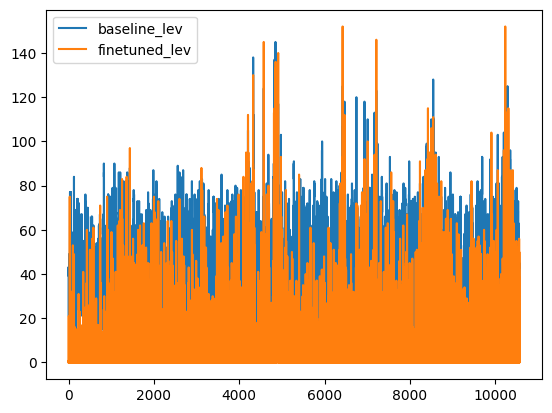

In [30]:
df[["baseline_lev", "finetuned_lev"]].plot()

It stands out that the baseline one is worse for almost every example.

# Summary

The notebook covered this points:
* General Question Answering considerations and problem definition.
* Model selection: DistilBert as a relatively lightweight model for fine-tuning convenience.
* Model fine-tuning: Use of HF Trainer to fine-tune the model, plus HP tuning, TensorBoard logging and monitoring, etc.
* Evaluation comparison: Use of HF Evaluate to compare results for both baseline and fine-tuned models, showing that the fine-tuned one clearly outperforms the initial one.

# References

* https://huggingface.co/docs/transformers/tasks/question_answering
* https://huggingface.co/learn/nlp-course/chapter7/7